In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import scipy
import pylab
import time

import seaborn as sns

# special matplotlib argument for improved plots
from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
df= pd.read_csv("Encoded_last.csv")

In [3]:
df.drop(['Unnamed: 0'],axis=1,inplace=True)

In [4]:
df.head()

,DATE,YEAR,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,ORG_apparentTemperature,ORG_cloudCover,ORG_dewPoint,ORG_humidity,...,DESTINATION_AIRPORT_DEN,DESTINATION_AIRPORT_DFW,DESTINATION_AIRPORT_IAH,DESTINATION_AIRPORT_LAS,DESTINATION_AIRPORT_LAX,DESTINATION_AIRPORT_ORD,DESTINATION_AIRPORT_PHX,DESTINATION_AIRPORT_SEA,DESTINATION_AIRPORT_SFO,DESTINATION_AIRPORT_nan
0,1.420092e+09,2015,1,1,4,1112,45.08,0.00,22.57,0.41,...,0,1,0,0,0,0,0,0,0,0
1,1.420092e+09,2015,1,1,4,1173,34.23,0.83,16.10,0.47,...,0,0,0,0,0,0,0,0,0,0
2,1.420092e+09,2015,1,1,4,2336,6.92,0.00,-1.98,0.66,...,0,0,0,0,0,0,0,0,0,0
3,1.420092e+09,2015,1,1,4,1197,45.08,0.00,22.57,0.41,...,0,0,1,0,0,0,0,0,0,0
4,1.420092e+09,2015,1,1,4,214,33.39,1.00,15.19,0.47,...,0,1,0,0,0,0,0,0,0,0


In [17]:
X=df.drop(['CANCELLED'],axis=1)
y=df['CANCELLED']

In [18]:
from sklearn.preprocessing import Imputer
imputer = Imputer()
X = imputer.fit_transform(X)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [19]:
#Reduce the size to 10%
from sklearn.model_selection import train_test_split
_, X, _, y = train_test_split(X,y,test_size=0.1, random_state=30, stratify=y)

In [35]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(ratio='minority')
X_sm, y_sm = smote.fit_sample(X, y)


In [11]:
print(len(y_sm[y_sm==1]))
print(len(y_sm[y_sm==0]))

print(len(y[y==1]))
print(len(y[y==0]))

39057
39057
405
39057


In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_sm,y_sm,test_size=0.3, random_state=30, stratify=y_sm)
#X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=30, stratify=y)

In [38]:
%time
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
# Steps for pipeline
param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
# Training using CV
gsearch2.fit(X_train, y_train)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 16.2 µs


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sam...      subsample=0.8, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'max_depth': range(5, 16, 2), 'min_samples_split': range(200, 1001, 200)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [39]:
print("best params is : ",gsearch2.best_params_)
print("best score is : ", gsearch2.best_score_)

best params is :  {'max_depth': 5, 'min_samples_split': 200}
best score is :  1.0


In [40]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, cohen_kappa_score
from sklearn import metrics

In [41]:
y_pred_test = gsearch2.predict(X_test)
y_pred_test_prob = gsearch2.predict_proba(X_test)

In [42]:
y_pred_test = gsearch2.predict(X_test)
#y_pred_test_prob = grid_search.predict_proba(X_test)
print("#####################")
print("Test data")
print("#####################")
print("F1: ", metrics.f1_score(y_test, y_pred_test))
print("Cohen Kappa: ", metrics.cohen_kappa_score(y_test, y_pred_test))
print("Brier: ", metrics.brier_score_loss(y_test, y_pred_test))
#print("LogLoss: ", metrics.log_loss(y_test, y_pred_test_prob))
print(metrics.classification_report(y_test, y_pred_test))
conf_matrix = metrics.confusion_matrix(y_test, y_pred_test)

#####################
Test data
#####################
F1:  1.0
Cohen Kappa:  1.0
Brier:  0.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     11717
         1.0       1.00      1.00      1.00     11718

   micro avg       1.00      1.00      1.00     23435
   macro avg       1.00      1.00      1.00     23435
weighted avg       1.00      1.00      1.00     23435



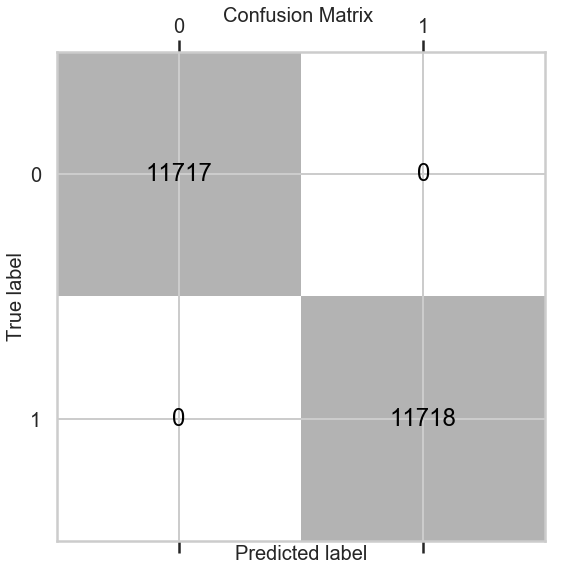

In [43]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(conf_matrix, alpha=0.3,cmap=plt.cm.gray_r)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center', fontsize=24,color ='k')
plt.title('Confusion Matrix ', size=20)
plt.xlabel('Predicted label', size=20)
plt.ylabel('True label', size=20)
ax.tick_params('x', labelsize = 20)
ax.tick_params('y', labelsize = 20)
plt.tight_layout()

In [18]:
from sklearn.metrics import confusion_matrix

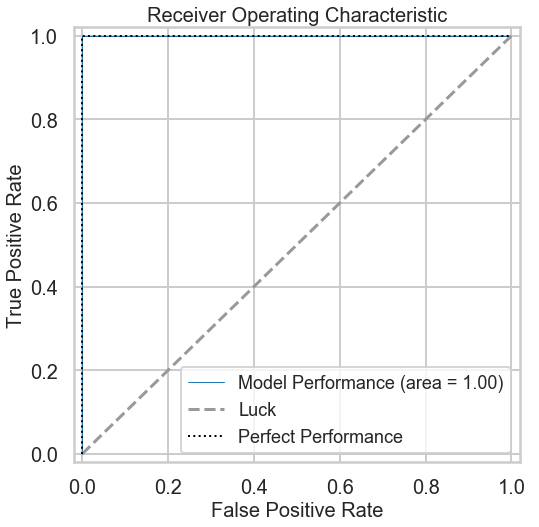

In [44]:
# ROC curve
fig1, ax1 = plt.subplots(figsize=(8, 8))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_prob[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='Model Performance (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], 
        [0, 1], 
        '--', 
        color=(0.6, 0.6, 0.6), 
        label='Luck')
    
plt.plot([0, 0, 1], 
        [0, 1, 1], 
        lw=2,
        linestyle=':',
        color='black',
        label='Perfect Performance')
        
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate', size=20)
plt.ylabel('True Positive Rate', size=20)
plt.title('Receiver Operating Characteristic', size=20)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.legend(loc="lower right", fontsize=18)
   

/anaconda3/lib/python3.7/site-packages/matplotlib/legend.py:497: UserWarning: Unrecognized location "top right". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


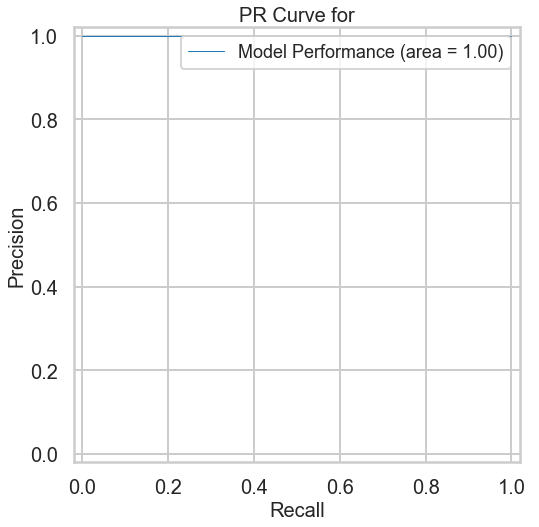

In [45]:
# PR curve
fig2, ax2 = plt.subplots(figsize=(8, 8))
prec, recall, thresholds = precision_recall_curve(y_test, y_pred_test_prob[:, 1])
#pr_auc = auc(prec, recall)
plt.plot(recall, prec, lw=1, label='Model Performance (area = %0.2f)' % 
             (metrics.average_precision_score(y_test, y_pred_test_prob[:, 1])))    
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('Recall', size=20)
plt.ylabel('Precision', size=20)
plt.title('PR Curve for', size=20)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.legend(loc="top right", fontsize=18)